In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler, LabelEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

# import seaborn as sns
import matplotlib.pyplot as plt

import os, sys

sys.path.append(os.path.abspath("../"))
# from src.helper import show_clustered_image, calculate_cmyk_percentage

import numpy as np

from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.preprocessing import PowerTransformer

## XGBoost

In [3]:
df = pd.read_csv("../outputs/csv/cmyk_of_a_pdf_file_by_dpi_kmeans_clustered.csv")
df = df[(df["dpi"] <= 100) & (df["library"] == "pymupdf")]
df.replace({500: 0, 750: 1, 1000: 2, 1500: 3, 2000: 4}, inplace=True)
df.reset_index(drop=True, inplace=True)
df

,library,dpi,converting_time,page,c,m,y,k,cmy,cmyk,price
0,pymupdf,1,0.030493,1,0.24,0.40,1.26,1.20,1.90,3.10,1
1,pymupdf,1,0.019641,2,1.73,1.51,0.00,8.96,3.24,12.20,0
2,pymupdf,1,0.005342,3,0.00,0.00,0.00,20.82,0.00,20.82,1
3,pymupdf,1,0.002484,4,0.00,0.00,0.00,24.39,0.00,24.39,1
4,pymupdf,1,0.002220,5,0.00,0.00,0.00,24.39,0.00,24.39,1
...,...,...,...,...,...,...,...,...,...,...,...
13255,pymupdf,100,0.160458,880,0.00,0.00,0.00,5.53,0.00,5.53,0
13256,pymupdf,100,0.169382,881,0.98,10.32,11.61,11.27,22.91,34.18,3
13257,pymupdf,100,0.144489,882,0.80,1.27,1.82,1.49,3.89,5.38,0
13258,pymupdf,100,0.162026,883,2.33,26.69,30.16,11.86,59.18,71.04,4


In [ ]:
X = df[df.dpi == 4][["cmy", "k", "price"]]
y = df[df.dpi == 4].price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)

In [ ]:
xgb_params = {
    "algo__objective": ["multi:softprob", "multi:softmax"],
    "algo__gamma": np.linspace(0, 0.8, 50),
    "algo__learning_rate": [0.001, 0.01, 0.05, 0.1],
    "algo__max_depth": [5, 10, 25, 45, 50, 55, 60],
}

classification_pipe = Pipeline([("algo", XGBClassifier())])


model = RandomizedSearchCV(
    classification_pipe,
    param_distributions=xgb_params,
    cv=4,
    scoring="f1_weighted",
    verbose=1,
)
model.fit(X_train, y_train)
print(model.best_params_)

y_pred = model.predict(X_test)
model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
{'algo__objective': 'multi:softprob', 'algo__max_depth': 60, 'algo__learning_rate': 0.05, 'algo__gamma': 0.3755102040816327}


(1.0, 0.9981475603119898, 1.0)

### Coba beberapa DPI

In [ ]:
dpi_le_100 = df.dpi.unique().tolist()

cv_results_df = pd.DataFrame(
    {
        "mean_fit_time": [],
        "std_fit_time": [],
        "mean_score_time": [],
        "std_score_time": [],
        "param_algo__objective": [],
        "param_algo__max_depth": [],
        "param_algo__learning_rate": [],
        "param_algo__gamma": [],
        "params": [],
        "split0_test_score": [],
        "split1_test_score": [],
        "split2_test_score": [],
        "split3_test_score": [],
        "mean_test_score": [],
        "std_test_score": [],
        "rank_test_score": [],
        "features": [],
        "dpi": [],
        "training_score": [],
        "best_score_cv": [],
        "testing_score": [],
    }
)

for dpi in dpi_le_100:
    for feature in [
        ["cmy", "k"],
        ["c", "m", "y", "cmyk"],
        ["c", "m", "y", "k", "cmyk"],
        ["cmy", "k", "cmyk"],
    ]:
        print(f"Training with {dpi} DPI and Features: {feature}")
        X = df[df.dpi == dpi][feature]
        y = df[df.dpi == dpi].price

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.33, stratify=y
        )

        xgb_params = {
            "algo__objective": ["multi:softprob", "multi:softmax"],
            "algo__gamma": np.linspace(0, 0.8, 50),
            "algo__learning_rate": [0.001, 0.01, 0.05, 0.1],
            "algo__max_depth": [5, 10, 25, 45, 50, 55, 60],
        }

        classification_pipe = Pipeline([("algo", XGBClassifier())])

        model = RandomizedSearchCV(
            classification_pipe,
            param_distributions=xgb_params,
            cv=5,
            scoring="f1_weighted",
            verbose=1,
        )
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test)

        temp = pd.DataFrame(model.cv_results_)
        temp["features"] = str(feature)
        temp["dpi"] = dpi
        temp["training_score"] = model.score(X_train, y_train)
        temp["best_score_cv"] = model.best_score_
        temp["testing_score"] = model.score(X_test, y_test)

        cv_results_df = pd.concat([cv_results_df, temp], ignore_index=True)

Training with 1 DPI and Features: ['cmy', 'k']
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Training with 1 DPI and Features: ['c', 'm', 'y', 'cmyk']
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Training with 1 DPI and Features: ['c', 'm', 'y', 'k', 'cmyk']
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Training with 1 DPI and Features: ['cmy', 'k', 'cmyk']
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Training with 2 DPI and Features: ['cmy', 'k']
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Training with 2 DPI and Features: ['c', 'm', 'y', 'cmyk']
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Training with 2 DPI and Features: ['c', 'm', 'y', 'k', 'cmyk']
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Training with 2 DPI and Features: ['cmy', 'k', 'cmyk']
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Training with 3 DPI and Features: ['cmy', 'k']
Fitting 5 folds for

In [146]:
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algo__objective,param_algo__max_depth,param_algo__learning_rate,param_algo__gamma,params,split0_test_score,...,split3_test_score,mean_test_score,std_test_score,rank_test_score,features,dpi,training_score,best_score_cv,testing_score,split4_test_score
0,0.435137,0.086445,0.006987,0.000277,multi:softmax,45,0.05,0.016327,"{'algo__objective': 'multi:softmax', 'algo__ma...",0.853864,...,0.874225,0.849008,0.033419,6.0,"['cmy', 'k']",1.0,0.928682,0.860025,0.878381,0.868255
1,0.254178,0.054890,0.007217,0.000610,multi:softprob,50,0.05,0.440816,"{'algo__objective': 'multi:softprob', 'algo__m...",0.846158,...,0.854115,0.853231,0.014849,2.0,"['cmy', 'k']",1.0,0.928682,0.860025,0.878381,0.870180
2,0.612505,0.582494,0.007840,0.001336,multi:softmax,60,0.1,0.587755,"{'algo__objective': 'multi:softmax', 'algo__ma...",0.879980,...,0.872791,0.860025,0.025133,1.0,"['cmy', 'k']",1.0,0.928682,0.860025,0.878381,0.870180
3,1.454446,1.175752,0.007776,0.000773,multi:softmax,5,0.01,0.179592,"{'algo__objective': 'multi:softmax', 'algo__ma...",0.853553,...,0.872791,0.851055,0.018951,5.0,"['cmy', 'k']",1.0,0.928682,0.860025,0.878381,0.869306
4,0.273244,0.147132,0.007339,0.000508,multi:softmax,5,0.1,0.359184,"{'algo__objective': 'multi:softmax', 'algo__ma...",0.853864,...,0.854115,0.843393,0.023051,10.0,"['cmy', 'k']",1.0,0.928682,0.860025,0.878381,0.870180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.223498,0.012884,0.009649,0.002084,multi:softprob,25,0.1,0.326531,"{'algo__objective': 'multi:softprob', 'algo__m...",1.000000,...,0.991326,0.983110,0.011855,3.0,"['cmy', 'k', 'cmyk']",100.0,0.998309,0.984813,0.989548,0.974337
596,0.279723,0.070741,0.009115,0.001392,multi:softmax,55,0.05,0.636735,"{'algo__objective': 'multi:softmax', 'algo__ma...",1.000000,...,0.991326,0.983110,0.011855,3.0,"['cmy', 'k', 'cmyk']",100.0,0.998309,0.984813,0.989548,0.974337
597,0.606342,0.287115,0.014876,0.011332,multi:softprob,55,0.001,0.538776,"{'algo__objective': 'multi:softprob', 'algo__m...",1.000000,...,0.991326,0.981034,0.013911,8.0,"['cmy', 'k', 'cmyk']",100.0,0.998309,0.984813,0.989548,0.965025
598,1.148007,1.425152,0.008052,0.000768,multi:softprob,5,0.001,0.37551,"{'algo__objective': 'multi:softprob', 'algo__m...",1.000000,...,0.991326,0.977523,0.015065,10.0,"['cmy', 'k', 'cmyk']",100.0,0.998309,0.984813,0.989548,0.965025


In [147]:
df_converting_time = pd.read_csv(
    "../outputs/csv/pdf_to_img_converting_time_by_libraries.csv"
)
df_converting_time = df_converting_time[
    (df_converting_time.dpi <= 100) & (df_converting_time.library == "pymupdf")
]
dpi_map = {x[1]["dpi"]: x[1]["converting_time"] for x in df_converting_time.iterrows()}
cv_results_df["converting_time"] = cv_results_df.dpi.replace(dpi_map)
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algo__objective,param_algo__max_depth,param_algo__learning_rate,param_algo__gamma,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,features,dpi,training_score,best_score_cv,testing_score,split4_test_score,converting_time
0,0.435137,0.086445,0.006987,0.000277,multi:softmax,45,0.05,0.016327,"{'algo__objective': 'multi:softmax', 'algo__ma...",0.853864,...,0.849008,0.033419,6.0,"['cmy', 'k']",1.0,0.928682,0.860025,0.878381,0.868255,9.124531
1,0.254178,0.054890,0.007217,0.000610,multi:softprob,50,0.05,0.440816,"{'algo__objective': 'multi:softprob', 'algo__m...",0.846158,...,0.853231,0.014849,2.0,"['cmy', 'k']",1.0,0.928682,0.860025,0.878381,0.870180,9.124531
2,0.612505,0.582494,0.007840,0.001336,multi:softmax,60,0.1,0.587755,"{'algo__objective': 'multi:softmax', 'algo__ma...",0.879980,...,0.860025,0.025133,1.0,"['cmy', 'k']",1.0,0.928682,0.860025,0.878381,0.870180,9.124531
3,1.454446,1.175752,0.007776,0.000773,multi:softmax,5,0.01,0.179592,"{'algo__objective': 'multi:softmax', 'algo__ma...",0.853553,...,0.851055,0.018951,5.0,"['cmy', 'k']",1.0,0.928682,0.860025,0.878381,0.869306,9.124531
4,0.273244,0.147132,0.007339,0.000508,multi:softmax,5,0.1,0.359184,"{'algo__objective': 'multi:softmax', 'algo__ma...",0.853864,...,0.843393,0.023051,10.0,"['cmy', 'k']",1.0,0.928682,0.860025,0.878381,0.870180,9.124531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.223498,0.012884,0.009649,0.002084,multi:softprob,25,0.1,0.326531,"{'algo__objective': 'multi:softprob', 'algo__m...",1.000000,...,0.983110,0.011855,3.0,"['cmy', 'k', 'cmyk']",100.0,0.998309,0.984813,0.989548,0.974337,98.536494
596,0.279723,0.070741,0.009115,0.001392,multi:softmax,55,0.05,0.636735,"{'algo__objective': 'multi:softmax', 'algo__ma...",1.000000,...,0.983110,0.011855,3.0,"['cmy', 'k', 'cmyk']",100.0,0.998309,0.984813,0.989548,0.974337,98.536494
597,0.606342,0.287115,0.014876,0.011332,multi:softprob,55,0.001,0.538776,"{'algo__objective': 'multi:softprob', 'algo__m...",1.000000,...,0.981034,0.013911,8.0,"['cmy', 'k', 'cmyk']",100.0,0.998309,0.984813,0.989548,0.965025,98.536494
598,1.148007,1.425152,0.008052,0.000768,multi:softprob,5,0.001,0.37551,"{'algo__objective': 'multi:softprob', 'algo__m...",1.000000,...,0.977523,0.015065,10.0,"['cmy', 'k', 'cmyk']",100.0,0.998309,0.984813,0.989548,0.965025,98.536494


In [ ]:
cv_results_df.to_csv(
    "../outputs/csv/cv_results_xgboost_1-100dpi_and_feature_tuning.csv", index=False
)

In [ ]:
cv_results_df.sort_values(
    by=["testing_score", "best_score_cv", "dpi", "converting_time"],
    ascending=[False, False, True, True],
).iloc[:50, :][["best_score_cv", "testing_score", "dpi", "converting_time", "features"]]

,best_score_cv,testing_score,dpi,converting_time,features
510,0.984039,1.000000,40.0,17.452735,"['cmy', 'k', 'cmyk']"
511,0.984039,1.000000,40.0,17.452735,"['cmy', 'k', 'cmyk']"
512,0.984039,1.000000,40.0,17.452735,"['cmy', 'k', 'cmyk']"
513,0.984039,1.000000,40.0,17.452735,"['cmy', 'k', 'cmyk']"
514,0.984039,1.000000,40.0,17.452735,"['cmy', 'k', 'cmyk']"
515,0.984039,1.000000,40.0,17.452735,"['cmy', 'k', 'cmyk']"
516,0.984039,1.000000,40.0,17.452735,"['cmy', 'k', 'cmyk']"
517,0.984039,1.000000,40.0,17.452735,"['cmy', 'k', 'cmyk']"
518,0.984039,1.000000,40.0,17.452735,"['cmy', 'k', 'cmyk']"
519,0.984039,1.000000,40.0,17.452735,"['cmy', 'k', 'cmyk']"


In [ ]:
cv_result_cleaned = cv_results_df.drop_duplicates(
    ["best_score_cv", "testing_score", "dpi", "converting_time", "features"]
)
cv_result_cleaned.sort_values(
    by=["testing_score", "best_score_cv", "dpi", "converting_time"],
    ascending=[False, True, False, True],
)[
    [
        "training_score",
        "testing_score",
        "dpi",
        "best_score_cv",
        "converting_time",
        "features",
    ]
]

,training_score,testing_score,dpi,best_score_cv,converting_time,features
510,1.000000,1.000000,40.0,0.984039,17.452735,"['cmy', 'k', 'cmyk']"
270,1.000000,0.993181,7.0,0.979339,8.131164,"['cmy', 'k', 'cmyk']"
380,1.000000,0.993151,10.0,0.975141,9.134181,"['c', 'm', 'y', 'k', 'cmyk']"
460,1.000000,0.993115,30.0,0.988141,12.581692,"['c', 'm', 'y', 'k', 'cmyk']"
500,1.000000,0.993111,40.0,0.989744,17.452735,"['c', 'm', 'y', 'k', 'cmyk']"
430,0.998309,0.989996,20.0,0.979481,10.254706,"['cmy', 'k', 'cmyk']"
420,0.998309,0.989718,20.0,0.986201,10.254706,"['c', 'm', 'y', 'k', 'cmyk']"
540,1.000000,0.989713,50.0,0.988043,24.475727,"['c', 'm', 'y', 'k', 'cmyk']"
590,0.998309,0.989548,100.0,0.984813,98.536494,"['cmy', 'k', 'cmyk']"
320,0.986470,0.989318,9.0,0.972134,7.832357,"['cmy', 'k']"


In [167]:
cv_result_cleaned.loc[270]['params']

{'algo__objective': 'multi:softmax',
 'algo__max_depth': 5,
 'algo__learning_rate': 0.001,
 'algo__gamma': 0.6040816326530613}

In [2]:
df = pd.read_csv("../outputs/csv/cmyk_of_a_pdf_file_by_dpi_kmeans_clustered.csv")
df = df[(df["dpi"] <= 100) & (df["library"] == "pymupdf")]
df.replace({500: 0, 750: 1, 1000: 2, 1500: 3, 2000: 4}, inplace=True)
df.reset_index(drop=True, inplace=True)
df

X = df[df.dpi == 7][["cmy", "k", "cmyk"]]
y = df[df.dpi == 7].price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)

xgb_params = {
    "algo__gamma": np.linspace(0, 0.8, 50),
    "algo__learning_rate": [0.001, 0.01, 0.05, 0.1],
    "algo__max_depth": [5, 10, 25, 45] + list(range(46, 66)),
}


# Label Encoding untuk y (target)
def label_encode(y):
    le = LabelEncoder()
    return le.fit_transform(y)

target_transformer = FunctionTransformer(lambda y: pd.Categorical(y).codes, validate=False)


classification_pipe = Pipeline(
    [
        # ('prep', target_transformer),
        ("algo", XGBClassifier(objective="multi:softmax"))
    ]
)

model = RandomizedSearchCV(
    classification_pipe,
    param_distributions=xgb_params,
    cv=5,
    scoring="f1_weighted",
    verbose=1,
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


print("Training Score: \t\t:", model.score(X_train, y_train))
print("5-Cross Validation Score\t:", model.best_score_)
print("Testing Score\t\t\t:", model.score(X_test, y_test))
print("Best Parameters\t\t\t:", model.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Training Score: 		: 0.9966290728707023
5-Cross Validation Score	: 0.9718247550035561
Testing Score			: 0.9827287314164236
Best Parameters			: {'algo__max_depth': 57, 'algo__learning_rate': 0.05, 'algo__gamma': 0.1306122448979592}


In [183]:
cm = classification_report(y_test, y_pred)
print(cm)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        59
           1       0.95      1.00      0.97        18
           2       0.95      0.98      0.97        63
           3       1.00      0.98      0.99       146
           4       1.00      1.00      1.00         6

    accuracy                           0.99       292
   macro avg       0.98      0.99      0.99       292
weighted avg       0.99      0.99      0.99       292



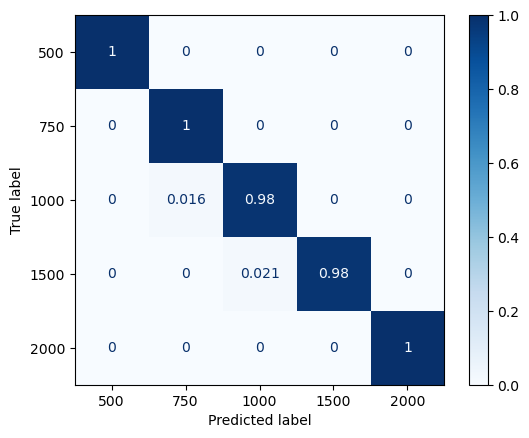

In [184]:
cm = confusion_matrix(y_test, y_pred, normalize="true")
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=[500, 750, 1000, 1500, 2000]
)
disp.plot(cmap="Blues")

In [186]:
import pickle

pickle.dump(model, open("../models/xgboost_98.64_cmy_k_cmyk_7_dpi.pkl", "wb"))
pickle.dump(
    model.best_estimator_, open("../models/xgboost_98.64_cmy_k_cmyk_7_dpi_small.pkl", "wb")
)

In [70]:
pd.DataFrame(model.cv_results_).columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_algo__objective', 'param_algo__max_depth',
       'param_algo__learning_rate', 'param_algo__gamma', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score'],
      dtype='object')

In [ ]:
pd.DataFrame(
    {
        "mean_fit_time": [],
        "std_fit_time": [],
        "mean_score_time": [],
        "std_score_time": [],
        "param_algo__objective": [],
        "param_algo__max_depth": [],
        "param_algo__learning_rate": [],
        "param_algo__gamma": [],
        "params": [],
        "split0_test_score": [],
        "split1_test_score": [],
        "split2_test_score": [],
        "split3_test_score": [],
        "mean_test_score": [],
        "std_test_score": [],
        "rank_test_score": [],
        "dpi": [],
        "training_score": [],
        "best_score_cv": [],
        "testing_score": [],
    }
)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algo__objective,param_algo__max_depth,param_algo__learning_rate,param_algo__gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,dpi,training_score,best_score_cv,testing_score


In [ ]:
a = pd.DataFrame({"a": [1, 2], "b": [3, 4]})
a

,a,b
0,1,3
1,2,4


In [ ]:
a["c"] = 3
a

,a,b,c
0,1,3,3
1,2,4,3


"['cmy', 'k', 'summ']"